# Домашнее задание по теме «Нейронные сети»

Сегодня мы продолжим работать с самописными слоями нейронных сетей, подогнав самописную функцию потерь под её библиотечный вариант.


## Библиотечная и кастомная реализация Cross-Entropy Loss

Во время семинара мы работали с крос-энтропией (Cross-Entropy Loss). Тогда мы сделали выводы, что библиотечная PyTotch-функция реализует более сложную логику, чем ту, которую мы кодировали сами.

**Чем отличаются функции потерь**

Стандартная кросс-энтропия в PyTorch автоматически применяет `softmax` и `log` к логитам перед расчётом потерь. Кастомная реализация, которую мы написали, этого не делает, так как у нас `sigmoid`. Из-за этого потери могут различаться.

**Почему потери не совпадают**

Без `softmax` и `log` в кастомной реализации числовая стабильность теряется, что может приводить к различиям в значениях потерь.

**Как привести к совпадению**

Чтобы кастомная реализация совпала с PyTorch, нужно вручную применить `softmax` и `log` к логитам перед расчётом потерь. В `backward` нужно учитывать производные для `softmax`.

Доработаем задачу из семинара, реализовав активацию через `LogSoftmax`.

### LogSoftmax

 > [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) — функция, объединяющая функцию активации [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) и операцию взятия логарифма Log.

Чтобы решить задачи многоклассовой классификации, обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить оценку вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}.$$

В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и $y_i=0$ в другом случае.

Записанная в таком виде функция потерь совпадает с выражением Cross-Entropy Loss. Её можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{i} \rightarrow \min.$$
В таком виде её удобно реализовывать.



### LogSumExp

При работе с экспонентами в машинном обучении, часто возникает проблема численной нестабильности. Она проявляется в двух случаях:

* **Переполнение** (`overflow`) — если значения слишком большие,
`exp(x)` может стать бесконечным (`inf`).
* **Потеря точности** (`underflow`) — если значения слишком маленькие, `exp(x)` превращается в ноль, и информация теряется.

Чтобы такого не случилось, можно вынести максимум из экспонент вместо того, чтобы считать сумму напрямую:

$$ log \Sigma_i e^{(x_i)} = m + log \Sigma_i e^{(x_i-m)}, $$

где $m = max(x_i)$.

Таким образом:

* Если все $x_i$ большие, вычитание $m$ предотвращает переполнение.
* Если все $x_i$ маленькие, сдвиг помогает отдалиться от нуля, предотвращая потерю точности.

## Задача 1 [5 баллов]

Реализуй слой `LogSoftmax` (без параметров), дополнив код ниже. **[5 баллов]**

Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` — пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трёхмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` — это матрица, у которой в каждой строке только одно ненулевое значение (необязательно единица).

<!-- Сейчас мы работаем с большим количеством математики и новым для вас функционалом PyTorch, поэтому задачки могут казаться сложными, непонятными и не интуитивными. Вот, что может помочь вам при работе над ними: -->

> **Подсказка.** Сейчас мы работаем с большим количеством математических формул и с новой темой — функционалом PyTorch. Решение задач может быть сложным и неинтуитивным. При работе над задачами могут помочь эти ссылки:
* [Документация PyTorch](https://pytorch.org/docs/stable/index.html) — весь функционал PyTorch, включая описания и примеры использорвания.
* [Stack Overflow](https://stackoverflow.com/questions) — любые вопросы по коду или возникающим ошибкам.


In [12]:
import torch
from torch.autograd import gradcheck

class LogSoftmaxFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        # Находим максимум по каждой строке (по классам), сохраняем его для числовой стабильности
        c, arg_m = inp.max(dim=1, keepdim=True)# Твой код

        # Создаём булевую маску, которая отмечает, какие элементы равны максимуму
        mask = (inp==c)# Твой код

        # Вычисляем logsumexp: log(sum(exp(inp - c))) для стабилизации softmax
        lse = torch.log(torch.sum(torch.exp(inp-c), dim=1, keepdim=True))# Твой код

        # Вычисляем log_softmax: inp - c - logsumexp(inp - c)
        output = inp-c-lse# Твой код

        # Сохраняем нормализованные входные данные и маску для backward
        ctx.save_for_backward(inp - c, mask)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Достаём сохранённые тензоры из forward
        norm_inp, mask = ctx.saved_tensors

        # Создаём булевую 3D-матрицу для выделения диагонали
        diag_bool = torch.eye(norm_inp.shape[1], norm_inp.shape[1]) \
                        .expand(norm_inp.shape[0], norm_inp.shape[1], norm_inp.shape[1]) > 0

        # Вычисляем сумму экспонент нормализованных входных данных (для нормализации softmax)
        softmax = torch.exp(norm_inp) / torch.sum(
            torch.exp(norm_inp), dim=1, keepdim=True
        )

        # Инициализируем матрицу Якоби, заполненную нулями
        J = -softmax.unsqueeze(1).expand(-1, norm_inp.shape[1], -1).clone()

        # Заполняем матрицу Якоби значениями производных softmax
        # J[i, j] = -softmax(x_j) для всех элементов
        # Твой код

        # Добавляем 1 к диагональным элементам (учёт частной производной d(log_softmax)/dx)
        J[diag_bool] += 1

        # Умножаем матрицу Якоби на градиент из следующего слоя
        grad_input = torch.bmm(grad_output.unsqueeze(1), J).squeeze(1)

        # Убираем лишнюю размерность и возвращаем градиенты
        return grad_input# Твой код

In [13]:
class LogSoftmax(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.logsoftmax = LogSoftmaxFunction.apply# Твой код — посмотри, как мы делали это в семинаре

    def forward(self, input):
        return self.logsoftmax(input)# Твой код — посмотри, как мы делали это в семинаре

Проверим градиенты.

In [14]:
# Если всё выполнено верно, то в выводе будет только 1 Warning

logsoftmax = LogSoftmaxFunction.apply
x = torch.rand((2,3), requires_grad=True)

assert gradcheck(logsoftmax, x, eps=5e-3)

/home/rlohaw/Homeworks/AI/.venv/lib/python3.10/site-packages/torch/autograd/gradcheck.py:922: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


In [15]:
# Если всё выполнено верно, то вывод будет пустой

our_softmax = LogSoftmax()
torch_softmax = torch.nn.LogSoftmax(dim=1)

assert torch.norm(our_softmax(x.float()) - torch_softmax(x)) < 1e-5

## Задача 2 [3 балла]

Отлично! Теперь нужно заново собрать весь пайплайн решения (пользуйся функциями из семинара), заменив в архитектурах `sigmoid` на выходе на `logsoftmax`.

Обучи самописную и PyTorch-модели так, чтобы значения `Accuracy` были сопоставимы для двух моделей. **[3 балла]**


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class CustomLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        return torch.matmul(x, self.W.T) + self.b


class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))


class CustomSigmoid(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = CustomLinear(input_dim, hidden_dim)
        self.relu = CustomReLU()
        self.linear2 = CustomLinear(hidden_dim, output_dim)
        self.logsoftmax = LogSoftmax()  

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.logsoftmax(x)
        return x


class CrossEntropyFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, activations, target):
        probs = torch.softmax(activations, dim=1)
        ctx.save_for_backward(probs, target)
        loss = -torch.log(probs[range(len(target)), target]).mean()
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        probs, target = ctx.saved_tensors
        batch_size = probs.shape[0]
        grad_input = probs.clone()
        tmp = torch.zeros_like(probs)
        tmp[torch.arange(batch_size), target] = -1.0
        grad_input = (grad_input + tmp) / batch_size
        grad_input = grad_input * grad_output
        return grad_input, None


class CrossEntropyCustom(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, activations, target):
        return CrossEntropyFunction.apply(activations, target)


class PyTorchModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.LogSoftmax()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x


def train(model, criterion, optimizer, data_loader, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for data, target in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}")


def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = torch.argmax(output, dim=1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    print(f"Accuracy: {100 * correct / total}%")


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = 784  
hidden_dim = 128
output_dim = 10  

custom_model = CustomModel(input_dim, hidden_dim, output_dim)
pytorch_model = PyTorchModel(input_dim, hidden_dim, output_dim)

optimizer_custom = torch.optim.SGD(custom_model.parameters(), lr=0.01)
optimizer_pytorch = torch.optim.SGD(pytorch_model.parameters(), lr=0.01)

criterion = CrossEntropyCustom()

print("Training Custom Model:")
train(custom_model, criterion, optimizer_custom, train_loader, epochs=5)

print("\nTraining PyTorch Model:")
train(pytorch_model, nn.CrossEntropyLoss(), optimizer_pytorch, train_loader, epochs=5)

print("\nTesting Custom Model:")
test(custom_model, test_loader)

print("\nTesting PyTorch Model:")
test(pytorch_model, test_loader)

Training Custom Model:
Epoch [1/5], Loss: 1.0767504290731222
Epoch [2/5], Loss: 0.5867391810742523
Epoch [3/5], Loss: 0.5113824698716593
Epoch [4/5], Loss: 0.47375532558986116
Epoch [5/5], Loss: 0.4500055497389104

Training PyTorch Model:


/home/rlohaw/Homeworks/AI/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/5], Loss: 0.8160917324297972
Epoch [2/5], Loss: 0.5244644225152062
Epoch [3/5], Loss: 0.47397284932545763
Epoch [4/5], Loss: 0.44699117927345383
Epoch [5/5], Loss: 0.42769423184364336

Testing Custom Model:
Accuracy: 82.88%

Testing PyTorch Model:
Accuracy: 83.46%


## Задача 3 [2 балла]

Мы уже познакомились с разными функциями активации, например: `ReLU`, `Sigmoid` и `Softmax`. Однако их существует гораздо больше.

Это задание — творческое и направлено на расширение кругозора. Проведи небольшое исследование, выбери **две функции активации** (по 1 баллу за каждую), реализуй их кастомные версии, а затем сравни с их имплементацией в PyTorch. **[2 балла]**

1. **Проверь на одинаковые выходные значения**

 Подай одинаковый вход (`input`) в обе функции и сравни `output`. Если они разные, возможно, ошибка в реализации.
2. **Проверь градиенты (gradcheck)**

 PyTorch предоставляет `torch.autograd.gradcheck()`, который проверяет правильность градиентов методом численного дифференцирования.
3. **Визуализируй выходы и градиенты**

 Построй графики: `input` → `output` и `input` → `gradient`.
4. **Проверь производительность (скорость выполнения)**

 Засеки время выполнения `.forward()` и `.backward()`.
Самописная функция, скорее всего, будет медленнее из-за неэффективной реализации.

ELU: Выходы совпадают? True
Swish: Выходы совпадают? True
Gradcheck для Custom ELU: True
Gradcheck для Custom Swish: True


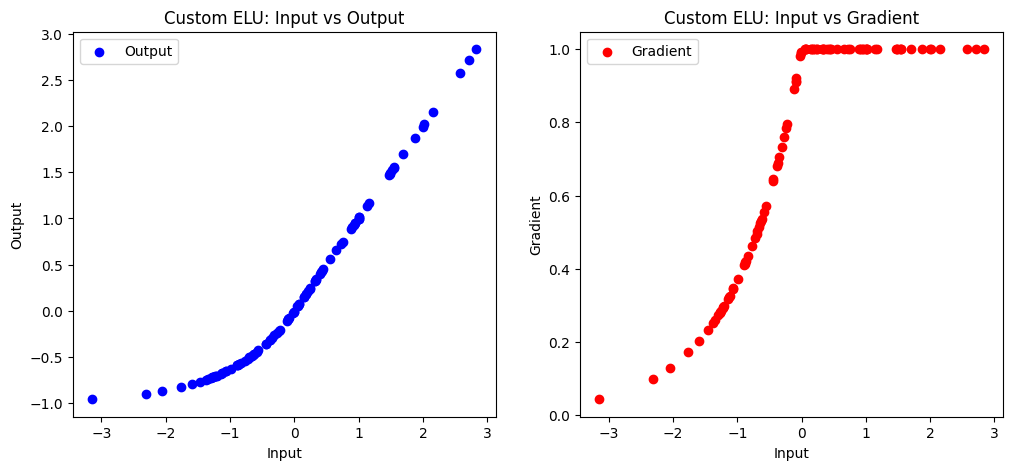

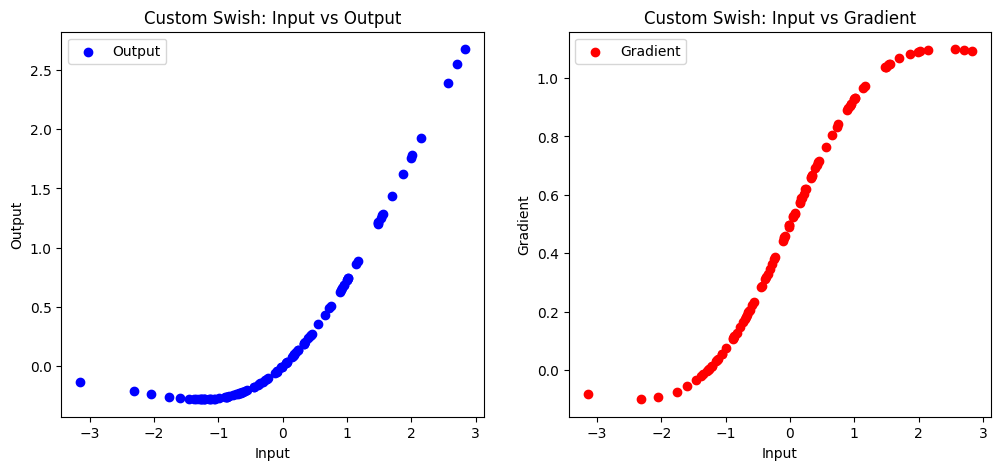

ELU:
Custom ELU: forward = 0.143567s, backward = 0.362345s
Builtin ELU: forward = 0.050183s, backward = 0.189563s

Swish:
Custom Swish: forward = 0.084363s, backward = 0.289915s
Builtin Swish: forward = 0.056885s, backward = 0.232665s


In [ ]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt



class CustomELU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, alpha=1.0):
        ctx.alpha = alpha
        ctx.save_for_backward(input)
        output = torch.where(input >= 0, input, alpha * (torch.exp(input) - 1))
        return output

    @staticmethod
    def backward(ctx, grad_output):
        (input,) = ctx.saved_tensors
        alpha = ctx.alpha
        grad_input = grad_output * torch.where(
            input >= 0, torch.ones_like(input), alpha * torch.exp(input)
        )
        return grad_input, None


class CustomELUModule(torch.nn.Module):
    def __init__(self, alpha=1.0):
        super(CustomELUModule, self).__init__()
        self.alpha = alpha

    def forward(self, input):
        return CustomELU.apply(input, self.alpha)


class CustomSwish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        sigmoid = torch.sigmoid(input)
        ctx.save_for_backward(input, sigmoid)
        return input * sigmoid

    @staticmethod
    def backward(ctx, grad_output):
        input, sigmoid = ctx.saved_tensors
        grad_input = grad_output * (sigmoid + input * sigmoid * (1 - sigmoid))
        return grad_input


class CustomSwishModule(torch.nn.Module):
    def forward(self, input):
        return CustomSwish.apply(input)


BuiltinELUModule = torch.nn.ELU(alpha=1.0)


# Встроенная Swish: определим через x * sigmoid(x), к сожалению нет в торче(
class BuiltinSwishModule(torch.nn.Module):
    def forward(self, input):
        return input * torch.sigmoid(input)


BuiltinSwishModule = BuiltinSwishModule()


torch.manual_seed(0)
input_data = torch.randn(100, requires_grad=True, dtype=torch.double)

custom_elu = CustomELUModule(alpha=1.0).double()
pt_elu = BuiltinELUModule.double()

output_custom_elu = custom_elu(input_data)
output_pt_elu = pt_elu(input_data)
print(
    "ELU: Выходы совпадают?",
    torch.allclose(output_custom_elu, output_pt_elu, atol=1e-6),
)

custom_swish = CustomSwishModule().double()
pt_swish = BuiltinSwishModule.double()

output_custom_swish = custom_swish(input_data)
output_pt_swish = pt_swish(input_data)
print(
    "Swish: Выходы совпадают?",
    torch.allclose(output_custom_swish, output_pt_swish, atol=1e-6),
)

input_for_gradcheck = input_data.clone().detach().requires_grad_(True)
gradcheck_elu = torch.autograd.gradcheck(
    lambda x: CustomELU.apply(x, 1.0), input_for_gradcheck
)
print("Gradcheck для Custom ELU:", gradcheck_elu)

input_for_gradcheck = input_data.clone().detach().requires_grad_(True)
gradcheck_swish = torch.autograd.gradcheck(CustomSwish.apply, input_for_gradcheck)
print("Gradcheck для Custom Swish:", gradcheck_swish)




def get_gradients(module, input_data):
    input_var = input_data.clone().detach().requires_grad_(True)
    output = module(input_var)
    output.sum().backward()
    return input_var, output, input_var.grad


in_elu, out_elu, grad_elu = get_gradients(custom_elu, input_data)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(in_elu.detach().numpy(), out_elu.detach().numpy(), c="blue", label="Output")
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Custom ELU: Input vs Output")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    in_elu.detach().numpy(), grad_elu.detach().numpy(), c="red", label="Gradient"
)
plt.xlabel("Input")
plt.ylabel("Gradient")
plt.title("Custom ELU: Input vs Gradient")
plt.legend()
plt.show()

in_swish, out_swish, grad_swish = get_gradients(custom_swish, input_data)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    in_swish.detach().numpy(), out_swish.detach().numpy(), c="blue", label="Output"
)
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Custom Swish: Input vs Output")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    in_swish.detach().numpy(), grad_swish.detach().numpy(), c="red", label="Gradient"
)
plt.xlabel("Input")
plt.ylabel("Gradient")
plt.title("Custom Swish: Input vs Gradient")
plt.legend()
plt.show()



def measure_time(module, input_data, n_iter=1000):
    input_var = input_data.clone().detach().requires_grad_(True)
    # Прогрев )))   (на серверных видюхах прогрев решает)
    for _ in range(10):
        out = module(input_var)
        out.sum().backward()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_iter):
        input_var = input_data.clone().detach().requires_grad_(True)
        out = module(input_var)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    forward_time = time.time() - start

    start = time.time()
    for _ in range(n_iter):
        input_var = input_data.clone().detach().requires_grad_(True)
        out = module(input_var)
        out.sum().backward()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    backward_time = time.time() - start

    return forward_time, backward_time


custom_elu = CustomELUModule(alpha=1.0).double()
pt_elu = BuiltinELUModule.double()
custom_swish = CustomSwishModule().double()
pt_swish = BuiltinSwishModule.double()

forward_custom_elu, backward_custom_elu = measure_time(custom_elu, input_data)
forward_pt_elu, backward_pt_elu = measure_time(pt_elu, input_data)

print("ELU:")
print(
    "Custom ELU: forward = {:.6f}s, backward = {:.6f}s".format(
        forward_custom_elu, backward_custom_elu
    )
)
print(
    "Builtin ELU: forward = {:.6f}s, backward = {:.6f}s".format(
        forward_pt_elu, backward_pt_elu
    )
)

forward_custom_swish, backward_custom_swish = measure_time(custom_swish, input_data)
forward_pt_swish, backward_pt_swish = measure_time(pt_swish, input_data)

print("\nSwish:")
print(
    "Custom Swish: forward = {:.6f}s, backward = {:.6f}s".format(
        forward_custom_swish, backward_custom_swish
    )
)
print(
    "Builtin Swish: forward = {:.6f}s, backward = {:.6f}s".format(
        forward_pt_swish, backward_pt_swish
    )
)